#### <b>Introduction</b> 
To give an overview of this phase, we will essentially be building everything from scratch. The datasets that we will be using for this project are the MNIST and the Fashion_MNIST dataset. <b> This notebook will focus on the MNIST dataset. </b> 

The MNIST dataset has a training set of 60,000 examples, and a test set of 10,000 examples. These examples consist of hand-written digits that belong to ten different classes (numbers 1 through 10). The given images have been size-normalized and centered in a fixed-size image. It would also be highly advisable to go through [this link](http://yann.lecun.com/exdb/mnist/) the information provided in this link to fully understand this dataset.


#### <b>Before You Begin</b>

The main methods correspond to the four steps of the training process of a NN which are as follows:
1. Initialize variables and initialize weights
2. Forward pass
3. Backward pass AKA Backpropagation
4. Weight Update AKA Gradient Descent


In [8]:
# Making all the necessary imports here

import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import Image
import pydot
from tqdm import tqdm_notebook
import seaborn as sns
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.datasets import make_moons
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
import cv2


In [9]:
# This function will be used to plot the confusion matrix at the end of this notebook

def plot_confusion_matrix(conf_mat):
    classes = ['1','2','3','4','5','6','7','8','9','10']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

class_labels = ['1','2','3','4','5','6','7','8','9','10']

In [10]:
# A random number that will be in plot title

rollnumber = 24100107

#### __Loading and Pre-processing the MNIST dataset__

The MNIST dataset has been already loaded using the imported keras APIs. We have to pre-process the given training and testing samples according to the implementation of our NN. 

In [11]:
# Loading the dataset using keras APIs
''' 
x_train = variable to store training images
y_train = variable to store training images' labels
x_test = variable to store test images
y_test = variable to store test images' labels
'''

classes = 10  # do not change this
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Sizes of test and training samples
print("Size of training samples matrix:", x_train.shape)
print("Size of testing samples matrix:", x_test.shape)

x_train = x_train/255.0
x_test = x_test/255.0

x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

new_y_train =[]

for y in y_train:
  arr = [0, 0, 0, 0, 0 ,0 ,0, 0, 0, 0]
  arr[y] = 1 #shouldnt this be y-1? same for below
  new_y_train.append(arr)

y_train = np.array( new_y_train)
#print(y_train.shape)
new_y_test =[]

for y in y_test:
  arr = [0, 0, 0, 0, 0 ,0 ,0, 0, 0, 0]
  arr[y] = 1
  new_y_test.append(arr)

y_test = np.array(new_y_test)

#print("Training samples: ", x_train)
#print("Testing samples: ", x_test)  

Size of training samples matrix: (60000, 28, 28)
Size of testing samples matrix: (10000, 28, 28)


#### __NN Implementation__
Our implementation of NN needs to use the `sigmoid` activation function for the hidden layer(s) and the `softmax` activation function for the output layer. The NN model we will be creating here will consits of only three layers: 1 input layer, 1 hidden layer and 1 output layer

In [12]:
class NeuralNetwork():
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        return (-np.sum(y_true * np.log(y_pred)))
    
    @staticmethod
    def accuracy(y_pred, y_true):

        correct_predictions = 0
        total = len(y_pred)
        for i in range(total):
          if y_pred[i] == y_true[i]:
            correct_predictions += 1

        accuracy = (correct_predictions/total)* 100

        return accuracy
    
    @staticmethod
    def softmax(x):
        denom = np.sum(np.exp(x))
        softmax_array = np.divide(np.exp(x),denom)

        return softmax_array
    
    @staticmethod
    def sigmoid(x):

        denom = 1 + np.exp(-x)
        return 1/denom
    
    def __init__(self, input_size, hidden_nodes, output_size):
        '''Creates a Feed-Forward Neural Network.
        The parameters represent the number of nodes in each layer (total 3). 
        Look at the inputs to the function'''
        
        self.num_layers = 3
        self.input_shape = input_size
        self.hidden_shape = hidden_nodes
        self.output_shape = output_size
        
        self.weights_ = []
        self.biases_ = []
        self.__init_weights()
    
    def __init_weights(self):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
                
        W_h = np.random.normal(size=(self.input_shape,self.hidden_shape))
        b_h = np.zeros(shape=(self.hidden_shape,))

        W_o = np.random.normal(size=(self.hidden_shape,self.output_shape))
        b_o = np.zeros(shape=(self.output_shape,))
        
        # self.weights_ becomes a list of np.arrays. 0th index has W_h and 1st index has W_o
        self.weights_.append(W_h)  
        self.weights_.append(W_o)  

        # self.biases_ becomes a list of np.arrays. 0th index has b_h and 1st index has b_o
        self.biases_.append(b_h)
        self.biases_.append(b_o)

    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        
        w_h = self.weights_[0]
        w_o = self.weights_[1]

        b_h = self.biases_[0]
        b_o = self.biases_[1]

        hidden_layer_activations = []
        for i in range(self.hidden_shape):
          aggregate = np.sum(np.multiply(input_data[0],w_h[:,i])) + b_h[i]
          #print("node ",i,aggregate)
          hidden_node_activation = self.sigmoid(aggregate)
          hidden_layer_activations.append(hidden_node_activation)
        
        hidden_layer_activations = np.array(hidden_layer_activations)
        activations = []
        activations.append(hidden_layer_activations)


        output_layer_activations = []
        output_layer_aggregates = []
        for i in range(self.output_shape):
          aggregate = np.sum(np.multiply(hidden_layer_activations,w_o[:,i])) + b_o[i]
          #print("output node ",i,aggregate)
          output_layer_aggregates.append(aggregate)
        
        output_layer_aggregates = np.array(output_layer_aggregates)
        #print(output_layer_aggregates)
        output_layer_activations = self.softmax(output_layer_aggregates)
        
        activations.append(output_layer_activations)
        activations = np.array(activations)
        
        return activations
    

    def sigmoid_derivative(self, x):
      return x*(1-x)

    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
                

        hidden_layer_activations = layer_activations[0]
        output_layer_activations = layer_activations[1]
        w_o = self.weights_[1]

        delta_for_w_o = np.eye(self.hidden_shape,self.output_shape)
        
        error_in_output_layer = output_layer_activations - targets[0]

        for i in range(self.output_shape):
          for j in range(self.hidden_shape):
            d_error_wrt_w_o = np.multiply(error_in_output_layer[i],hidden_layer_activations[j])
            delta_for_w_o[j][i] = d_error_wrt_w_o
        
        
        #delta_for_w_o = np.multiply((1/self.input_shape),delta_for_w_o) 

        delta_for_b_o = []
        for i in range(self.output_shape):
          #delta_for_b_o[i] = np.multiply((1/self.input_shape),error_in_output_layer[i])
          delta_for_b_o.append( error_in_output_layer[i] )

        delta_for_b_o = np.array(delta_for_b_o)

        # print(w_o.shape)
        # print("w_o[0,:].shape",w_o[0,:].shape)
        # print("error_in_output_layer.shape",error_in_output_layer.shape)

        error_in_hidden_layer =  []
        
        #print("hidden_layer_activations",hidden_layer_activations)

        for i in range(self.hidden_shape):
          error_in_hidden_layer.append( np.sum( w_o[i,:] * error_in_output_layer) )
        
        error_in_hidden_layer = np.array(error_in_hidden_layer)
       

        derivative_sigmoid = []
        for i in range(hidden_layer_activations.shape[0]):
          
          derivative_sigmoid.append( self.sigmoid_derivative( hidden_layer_activations[i] ) )

        derivative_sigmoid = np.array(derivative_sigmoid)
        #print("derivative_sigmoid",derivative_sigmoid)

        error_in_hidden_layer = np.multiply( error_in_hidden_layer , derivative_sigmoid)
        

        delta_for_b_h = []
        for i in range(self.hidden_shape):
          delta_for_b_h.append( error_in_hidden_layer[i]  )

        delta_for_b_h = np.array(delta_for_b_h)
        
        deltas = []
        deltas.append(error_in_hidden_layer)
        deltas.append(delta_for_b_h)
        deltas.append(delta_for_w_o)
        deltas.append(delta_for_b_o)
        deltas = np.array(deltas)

        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        
        error_in_hidden_layer = deltas[0]

        #delta_for_w_h = np.eye(self.input_shape,self.hidden_shape)

        delta_for_w_h = []
        #print(error_in_hidden_layer[0])
        #print(layer_inputs[0][0].shape) #(1, 784)


        for i in range(self.input_shape):
            
            delta_for_w_h.append( np.multiply(  layer_inputs[0][0][i] , error_in_hidden_layer  ) )
        
        
        delta_for_w_h = np.array(delta_for_w_h)
        
        delta_for_b_h = deltas[1]
        delta_for_w_o = deltas[2]
        delta_for_b_o = deltas[3]
    

        w_h = self.weights_[0]
        w_o = self.weights_[1]
        b_h = self.biases_[0]
        b_o = self.biases_[1]

        w_h = w_h - lr*delta_for_w_h
        b_h = b_h - lr*delta_for_b_h

        w_o = w_o - lr*delta_for_w_o
        b_o = b_o - lr*delta_for_b_o
        
        self.weights_[0] = w_h
        self.weights_[1] = w_o

        self.biases_[0] = b_h
        self.biases_[1] = b_o
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
            history = []
            for epoch in tqdm_notebook(range(epochs)):
                num_samples = Xs.shape[0]
                for i in range(num_samples):

                    sample_input = Xs[i,:].reshape((1,self.input_shape))
                    sample_target = Ys[i,:].reshape((1,self.output_shape))
                    
                    activations = self.forward_pass(sample_input)   # Call forward_pass function 
                    deltas = self.backward_pass(sample_target, activations)    # Call backward_pass function 
                    layer_inputs = [sample_input] + activations[:-1]
                    
                    # Call weight_update function 
                    self.weight_update(deltas, layer_inputs, lr)
                
                preds = self.predict(Xs)   # Call predict function 

                current_loss = self.cross_entropy_loss(preds, Ys)
                
                if  epoch==epochs-1:
                  confusion_mat=confusion_matrix(Ys.argmax(axis=1), preds.argmax(axis=1),labels=np.arange(10))  
                  plot_confusion_matrix(confusion_mat)
                  report = classification_report(Ys, np_utils.to_categorical(preds.argmax(axis=1),num_classes=classes), target_names=class_labels)
                  print(report)
                history.append(current_loss)
            return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        nodes_per_layer = [self.input_shape, self.hidden_shape, self.output_shape]
        for i in range(self.num_layers-1):
            for n1 in range(nodes_per_layer[i]):
                for n2 in range(nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

In [13]:
# These are what we call the hyperparameters.

INPUT_SIZE = 784       # must be an int, this number represents the numeber of nodes/neurons in the input layer of the network
HIDDEN_NODES = 20     # must be an int, this number represents the numeber of nodes/neurons in the only hidden layer of the network
OUTPUT_SIZE = 10      # must be an int, this number represents the numeber of nodes/neurons in the output layer of the network
EPOCH = 100            # must be an int
LEARNING_RATE = 0.01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


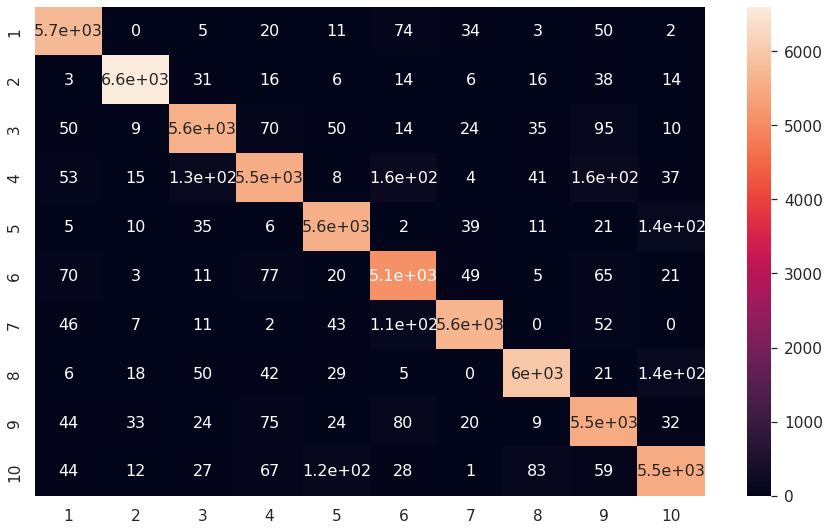

              precision    recall  f1-score   support

           1       0.95      0.97      0.96      5923
           2       0.98      0.98      0.98      6742
           3       0.95      0.94      0.94      5958
           4       0.94      0.90      0.92      6131
           5       0.95      0.95      0.95      5842
           6       0.91      0.94      0.93      5421
           7       0.97      0.95      0.96      5918
           8       0.97      0.95      0.96      6265
           9       0.91      0.94      0.92      5851
          10       0.93      0.93      0.93      5949

   micro avg       0.95      0.95      0.95     60000
   macro avg       0.94      0.95      0.94     60000
weighted avg       0.95      0.95      0.95     60000
 samples avg       0.95      0.95      0.95     60000

Runtime of the algorithm is  18099.056  seconds


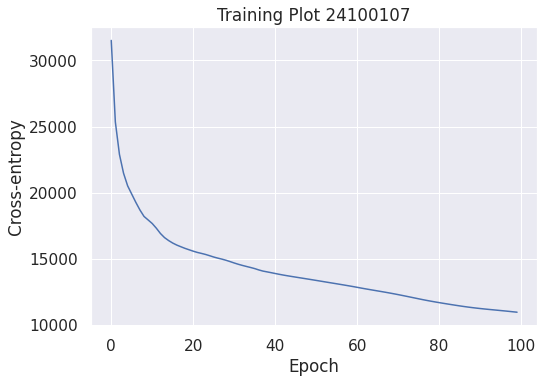

In [14]:
start = time.time()

nn = NeuralNetwork(input_size = INPUT_SIZE, hidden_nodes = HIDDEN_NODES, output_size = OUTPUT_SIZE)
history = nn.fit(x_train, y_train, epochs=EPOCH, lr=LEARNING_RATE)
plt.plot(history)
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber))
end = time.time()

print("Runtime of the algorithm is ", round((end - start),3)," seconds")

In [15]:
nn.evaluate(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(2816.2811556887978, 92.14)